In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Model

$$
\begin{aligned}
y_t & = d + x_t \beta_{x,t} + w_t \beta_{w,t} + \varepsilon_t \hspace{4em} \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\begin{bmatrix} \beta_{x,t} \\ \beta_{w,t} \end{bmatrix} & = \begin{bmatrix} \beta_{x,t-1} \\ \beta_{w,t-1} \end{bmatrix} + \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \hspace{3.7em} \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{\beta, x}^2 & 0 \\ 0 & \sigma_{\beta, w}^2 \end{bmatrix} \right )
\end{aligned}
$$

In [4]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='approximate_diffuse') #diffuse

        # If the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff']

    @property
    def start_params(self):
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001]
        return params

    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        #These are variances, so make sure they are positive:
        constrained[1:] = constrained[1:]**2
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[1:] = unconstrained[1:]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])


## Simulated data: drifting coefficients

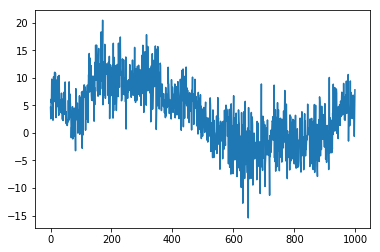

In [28]:
nobs = 1000

rs = np.random.RandomState(seed=93572)

d = 5
var_y = 5
var_coeff_x = 0.01
var_coeff_w = 0.5

x_t = rs.uniform(size=nobs)
w_t = rs.uniform(size=nobs)
eps = rs.normal(scale=var_y**0.5, size=nobs)

beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x**0.5))
beta_w = np.cumsum(rs.normal(size=nobs, scale=var_coeff_w**0.5))

y_t = d + beta_x * x_t + beta_w * w_t + eps

plt.plot(y_t);

### Fit with our model class

In [6]:
mod = TVRegression(y_t, x_t, w_t)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -2350.662
Date:                Thu, 27 Jun 2019   AIC                           4709.324
Time:                        08:22:56   BIC                           4728.955
Sample:                             0   HQIC                          4716.785
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0548      0.202     25.050      0.000       4.659       5.450
var.e           5.1240      0.249     20.571      0.000       4.636       5.612
var.x.coeff     0.0468      0.022      2.097    

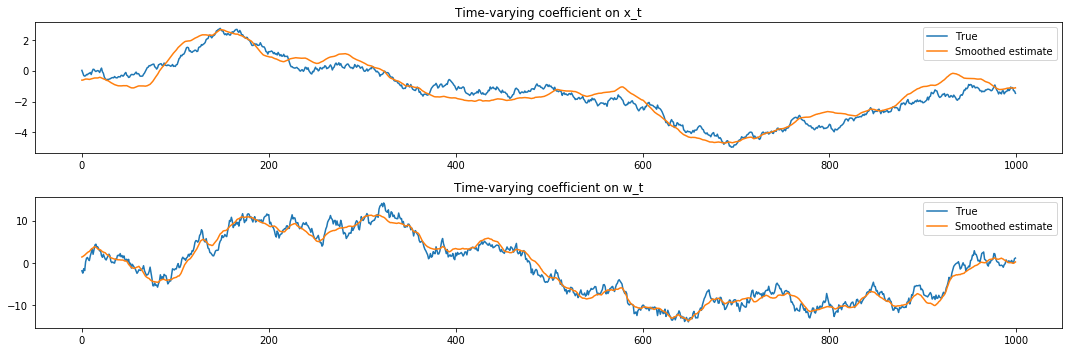

In [7]:
fig, axes = plt.subplots(2, figsize=(15, 5))

ss = pd.DataFrame(res.smoothed_state.T, columns=['x', 'w'])

axes[0].plot(beta_x, label='True')
axes[0].plot(ss['x'], label='Smoothed estimate')
axes[0].set(title='Time-varying coefficient on x_t')
axes[0].legend()

axes[1].plot(beta_w, label='True')
axes[1].plot(ss['w'], label='Smoothed estimate')
axes[1].set(title='Time-varying coefficient on w_t')
axes[1].legend()

fig.tight_layout();

## Model with parameters in transition matrix

$$
\begin{aligned}
y_t & = d + x_t \beta_{x,t} + w_t \beta_{w,t} + \varepsilon_t \hspace{4em} \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\begin{bmatrix} \beta_{x,t} \\ \beta_{w,t} \end{bmatrix} & = 
\begin{bmatrix} \rho_1 \hspace{1em} 0 \\ 0 \hspace{1em} \rho_2 \end{bmatrix}
\begin{bmatrix} \beta_{x,t-1} \\ \beta_{w,t-1} \end{bmatrix} + \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \hspace{3.7em} \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{\beta, x}^2 & 0 \\ 0 & \sigma_{\beta, w}^2 \end{bmatrix} \right )
\end{aligned}
$$

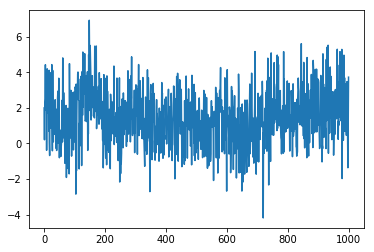

In [53]:
nobs = 1000

rs = np.random.RandomState(seed=93572)

d = 1.5
var_y = 2
var_coeff_x = 0.01
var_coeff_w = 0.02
rho1 = 0.98
rho2 = 0.96

x_t = rs.uniform(size=nobs)
w_t = rs.uniform(size=nobs)
eps = rs.normal(scale=var_y**0.5, size=nobs)

beta_x = np.empty(nobs)
beta_x[0] = rs.normal(size=1, scale=var_coeff_x**0.5)
for i in range(nobs-1):
    beta_x[i+1] = rho1*beta_x[i] + rs.normal(size=1, scale=var_coeff_x**0.5)
    
beta_w = np.empty(nobs)
beta_w[0] = rs.normal(size=1, scale=var_coeff_w**0.5)
for i in range(nobs-1):
    beta_w[i+1] = rho1*beta_w[i] + rs.normal(size=1, scale=var_coeff_w**0.5)


y_t = d + beta_x * x_t + beta_w * w_t + eps

plt.plot(y_t);

In [55]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='approximate_diffuse')

        # If the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        #self.ssm['transition'] = np.eye(self.k_states)
        self.ssm['transition'] = [[0.7, 0.], [0., 0.5]]

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff',
               'rho1', 'rho2']

    @property
    def start_params(self):
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001, 0.2, 0.5]
        return params

    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        #These are variances, so make sure they are positive:
        constrained[1:] = constrained[1:]**2
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[1:] = unconstrained[1:]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])
        self['transition', 0, 0] = params[4]
        self['transition', 1, 1] = params[5]


mod = TVRegression(y_t, x_t, w_t)
res = mod.fit(maxiter=500)

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -1820.700
Date:                Thu, 27 Jun 2019   AIC                           3653.400
Time:                        08:49:56   BIC                           3682.846
Sample:                             0   HQIC                          3664.591
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       1.4845      0.098     15.183      0.000       1.293       1.676
var.e           1.9995      0.096     20.832      0.000       1.811       2.188
var.x.coeff     0.0364      0.020      1.822    

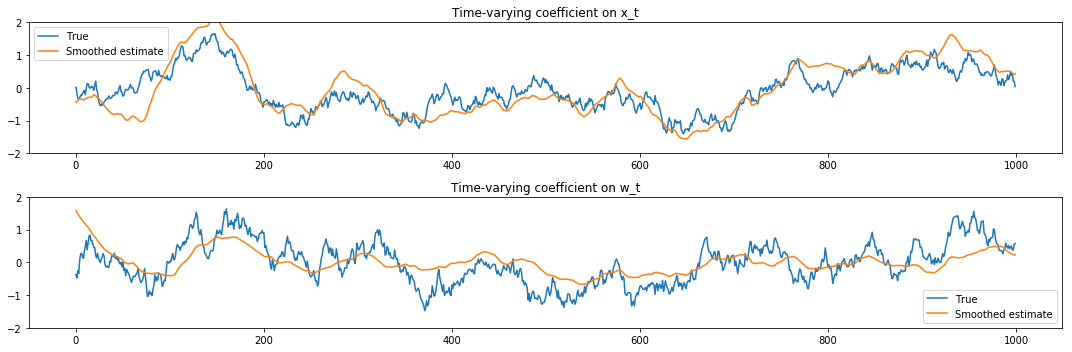

In [56]:
fig, axes = plt.subplots(2, figsize=(15, 5))

ss = pd.DataFrame(res.smoothed_state.T, columns=['x', 'w'])

axes[0].plot(beta_x, label='True')
axes[0].plot(ss['x'], label='Smoothed estimate')
axes[0].set(title='Time-varying coefficient on x_t')
axes[0].set_ylim(-2, 2)
axes[0].legend()


axes[1].plot(beta_w, label='True')
axes[1].plot(ss['w'], label='Smoothed estimate')
axes[1].set(title='Time-varying coefficient on w_t')
axes[1].set_ylim(-2, 2)
axes[1].legend()

fig.tight_layout();

## AR(2) model

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm

# True model parameters
nobs = int(1e3)
true_phi = np.r_[0.5, -0.2]
true_sigma = 1**0.5

# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endog = lfilter([1], np.r_[1, -true_phi], disturbances)

# Construct the model
class AR2(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                                  [1, 0]]
        self['selection', 0, 0] = 1

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,1]  # these are very simple

# Create and fit the model
mod = AR2(endog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                            AR2   Log Likelihood               -1389.437
Date:                Thu, 27 Jun 2019   AIC                           2784.874
Time:                        08:08:30   BIC                           2799.598
Sample:                             0   HQIC                          2790.470
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4395      0.030     14.730      0.000       0.381       0.498
param.1       -0.2055      0.032     -6.523      0.000      -0.267      -0.144
param.2        0.9425      0.042     22.413      0.0